In [1]:
!pip install transformers datasets scikit-learn matplotlib biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 88.8 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset
from Bio import SeqIO
import pandas as pd
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, AutoModelForMaskedLM, Trainer, TrainingArguments, pipeline


In [3]:
# Data paths
train_data_path = '/content/drive/MyDrive/PLM/ SwissprotDatasets/BalancedSwissprot/train.csv'
test_data_path = '/content/drive/MyDrive/PLM/ SwissprotDatasets/BalancedSwissprot/valid.csv'

In [4]:
# Load your train data
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [5]:
train_df.head()

,AC,EC,OC,UniRef90,UniRef50,EmblCdsId,Sequence,UniRef100
0,P9WQC2,1.1.1.1,Bacteria,UniRef90_P9WQC2,UniRef50_P9WQC2,AAK45848.1,ATGTCGGACGGCGCGGTGGTACGGGCATTGGTATTGGAGGCGCCGC...,UniRef100_P9WQC2
1,P50381,1.1.1.1,Archaea,UniRef90_P39462,UniRef50_P39462,CAA87591.1,ATGAGAGCAGTTAGATTAGTAGAAATAGGAAAACCTCTCGTTTTAA...,UniRef100_P50381
2,Q0KDL6,1.1.1.1,Bacteria,UniRef90_Q0KDL6,UniRef50_Q0KDL6,CAJ91905.1,ATGACCGCAATGATGAAAGCCGCCGTTTTTGTCGAGCCTGGCCGGA...,UniRef100_Q0KDL6
3,P42327,1.1.1.1,Bacteria,UniRef90_P42327,UniRef50_P42327,CAA80989.1,GTGAAAGCAGCAGTAGTTAACGAATTTAAAAAAGCACTTGAAATTA...,UniRef100_P42327
4,P9WQB9,1.1.1.1,Bacteria,UniRef90_P9WQB8,UniRef50_P81747,CCP45895.1,ATGAAAACCACCGCGGCGGTACTGTTCGAGGCGGGCAAACCGTTCG...,UniRef100_P9WQB8


In [6]:
print('Number of class: ',len(train_df['EC'].unique()))

Number of class:  2228


In [7]:
# Mapping EC numbers to indices
ec_classes = [str(i) for i in range(len(train_df['EC'].unique()))]
ec_to_index = {ec: i for i, ec in enumerate(ec_classes)}
index_to_ec = {i: ec for ec, i in ec_to_index.items()}
NUM_CLASSES = len(ec_classes)

In [8]:
train_df = train_df[train_df['Sequence'].str.len() > 20]  # remove short sequences
test_df = test_df[test_df['Sequence'].str.len() > 20]  # remove short sequences

In [9]:
train_df = train_df.iloc[0:5000,:]
test_df = test_df.iloc[0:2000,:]

In [10]:
# === Format sequences with spaces between amino acids ===
def format_sequence(seq):
    return ' '.join(list(seq.strip()))

train_df['spaced_sequence'] = train_df['Sequence'].apply(format_sequence)
test_df['spaced_sequence'] = test_df['Sequence'].apply(format_sequence)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [11]:
train_df.head()

,AC,EC,OC,UniRef90,UniRef50,EmblCdsId,Sequence,UniRef100,spaced_sequence
0,P9WQC2,1.1.1.1,Bacteria,UniRef90_P9WQC2,UniRef50_P9WQC2,AAK45848.1,ATGTCGGACGGCGCGGTGGTACGGGCATTGGTATTGGAGGCGCCGC...,UniRef100_P9WQC2,A T G T C G G A C G G C G C G G T G G T A C G ...
1,P50381,1.1.1.1,Archaea,UniRef90_P39462,UniRef50_P39462,CAA87591.1,ATGAGAGCAGTTAGATTAGTAGAAATAGGAAAACCTCTCGTTTTAA...,UniRef100_P50381,A T G A G A G C A G T T A G A T T A G T A G A ...
2,Q0KDL6,1.1.1.1,Bacteria,UniRef90_Q0KDL6,UniRef50_Q0KDL6,CAJ91905.1,ATGACCGCAATGATGAAAGCCGCCGTTTTTGTCGAGCCTGGCCGGA...,UniRef100_Q0KDL6,A T G A C C G C A A T G A T G A A A G C C G C ...
3,P42327,1.1.1.1,Bacteria,UniRef90_P42327,UniRef50_P42327,CAA80989.1,GTGAAAGCAGCAGTAGTTAACGAATTTAAAAAAGCACTTGAAATTA...,UniRef100_P42327,G T G A A A G C A G C A G T A G T T A A C G A ...
4,P9WQB9,1.1.1.1,Bacteria,UniRef90_P9WQB8,UniRef50_P81747,CCP45895.1,ATGAAAACCACCGCGGCGGTACTGTTCGAGGCGGGCAAACCGTTCG...,UniRef100_P9WQB8,A T G A A A A C C A C C G C G G C G G T A C T ...


In [12]:
dataset_train = Dataset.from_pandas(train_df[['spaced_sequence']])
dataset_test = Dataset.from_pandas(test_df[['spaced_sequence']])

In [14]:
# === Tokenize sequences ===
def tokenize_fn(examples):
    return tokenizer(
        examples['spaced_sequence'],
        padding='max_length',
        truncation=True,
        max_length=512
    )
tokenized_dataset_train = dataset_train.map(tokenize_fn, batched=True)
tokenized_dataset_test = dataset_test.map(tokenize_fn, batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

NameError: name 'tokenizer' is not defined

In [13]:
# === Data Collator for 15% Random Masking ===
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

NameError: name 'tokenizer' is not defined

In [15]:
from sklearn.preprocessing import LabelEncoder
from transformers import DataCollatorWithPadding

def load_ec_dataset(df, tokenizer, max_length=512):
    """
    Prepares a dataset from a DataFrame with columns ['sequence', 'ec_number'].

    Args:
        df (pd.DataFrame): DataFrame containing 'sequence' and 'ec_number'.
        tokenizer (PreTrainedTokenizer): HuggingFace tokenizer.
        max_length (int): Maximum sequence length to tokenize.

    Returns:
        dataset (Dataset): HuggingFace Dataset with tokenized inputs and labels.
        label_encoder (LabelEncoder): For decoding predicted labels later.
    """
    # Encode EC numbers into integer labels
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['EC'])

    # Tokenize sequences
    def tokenize_function(examples):
        return tokenizer(
            examples["spaced_sequence"],
            padding="max_length",
            truncation=True,
            max_length=max_length
        )

    dataset = Dataset.from_pandas(df[['spaced_sequence', 'label']])
    dataset = dataset.map(tokenize_function, batched=True)
    # dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label']) # Removed this line

    return dataset, label_encoder

In [ ]:
# train_dataset = Dataset.from_pandas(train_df[['spaced_sequence', 'EC']])
# test_dataset = Dataset.from_pandas(test_df[['spaced_sequence', 'EC']])

In [16]:
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)

# Prepare datasets
train_dataset, label_encoder = load_ec_dataset(train_df, tokenizer)
test_dataset, _ = load_ec_dataset(test_df, tokenizer)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [17]:
num_labels = len(label_encoder.classes_)
model = AutoModelForSequenceClassification.from_pretrained("Rostlab/prot_bert", num_labels=num_labels)

# Evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted')
    }

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# Trainer
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amartyahatua to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,6.217600,6.216465,0.005000,0.000050
2,6.216100,6.211948,0.005000,0.000050
3,6.216000,6.214694,0.000000,0.000000


TrainOutput(global_step=1875, training_loss=6.216574869791667, metrics={'train_runtime': 1433.7779, 'train_samples_per_second': 10.462, 'train_steps_per_second': 1.308, 'total_flos': 1.748509599744e+16, 'train_loss': 6.216574869791667, 'epoch': 3.0})

In [19]:
import seaborn as sns

# Evaluate
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)



Evaluation Results: {'eval_loss': 6.216464996337891, 'eval_accuracy': 0.005, 'eval_f1': 4.9751243781094526e-05, 'eval_runtime': 53.0352, 'eval_samples_per_second': 37.711, 'eval_steps_per_second': 4.714, 'epoch': 3.0}


In [20]:
# Predict
preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)



In [22]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        10
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


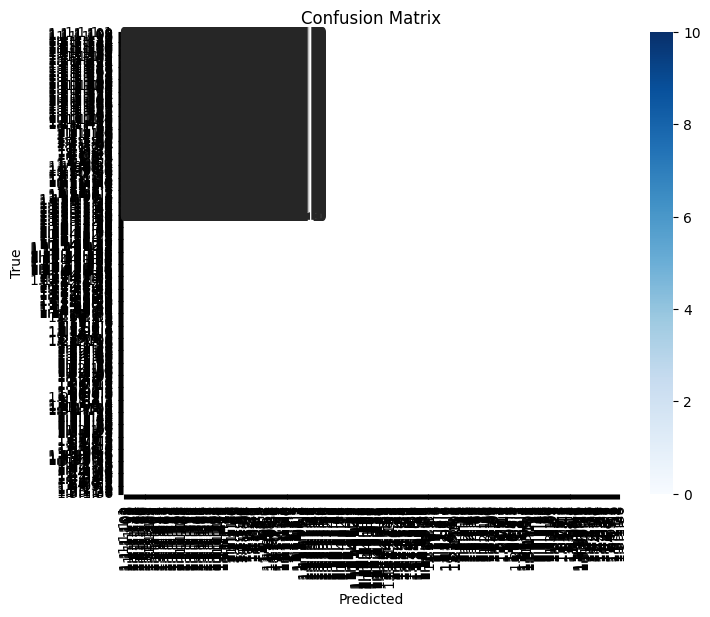

In [23]:

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
